<a href="https://colab.research.google.com/github/nashapir/Vision-Projects/blob/main/Architectural_Sketch_Renderer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mesh Renderer for Architectural Sketch-Based Modeling

A reinforcement learning system which uses differntiable rendering to iteratively deform and refine an existing rectilinear mesh until its silhouette resembles that of an input sketch, thus creating a 3D "block version."

## 0. Install and Import modules

In [1]:
!pip install torch torchvision
import os
import sys
import torch
import torch.nn as nn
if torch.__version__=='1.6.0+cu101' and sys.platform.startswith('linux'):
    !pip install pytorch3d
else:
    need_pytorch3d=False
    try:
        import pytorch3d
    except ModuleNotFoundError:
        need_pytorch3d=True
    if need_pytorch3d:
        !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
        !tar xzf 1.10.0.tar.gz
        os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   118  100   118    0     0    627      0 --:--:-- --:--:-- --:--:--   624
100  404k    0  404k    0     0   824k      0 --:--:-- --:--:-- --:--:--  824k
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-iclm8v_3
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-iclm8v_3
  Running command git checkout -q 18ce14cd31a2f1c99e16d727e1755156c360453a
     |████████████████████████████████| 276kB 13.8MB/s 
  Created wheel for pytorch3d: filename=pytorch3d-0.3.0-cp36-cp36m-linux_x86_64.whl size=20509247 sha256=724fb6a4c3d8d5a4552423696c3819778567088908e23fa1c54afac0a8ae55e7
  Stored in directory: /tmp/pip-ephem-wheel-cache-m90sb80i/wheels/89/69/08/d864f516508b5d943259c6088baa150ebdd3659b5dde4e3571
  Created wheel for fvcore: filename

In [2]:
import torch
from pytorch3d.utils import ico_sphere
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj, load_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
from os import path
sys.path.append(os.path.abspath(''))

# install kornia
!pip install git+https://github.com/kornia/kornia
import kornia

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



  Cloning https://github.com/kornia/kornia to /tmp/pip-req-build-f3vact_a
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-f3vact_a
  Created wheel for kornia: filename=kornia-0.4.2+ab3ff67-py2.py3-none-any.whl size=238883 sha256=e83eedf8c865ec5e4907a21be9cc7ebd336f74633bc6a925063cc39d566b4966
  Stored in directory: /tmp/pip-ephem-wheel-cache-fglsazsp/wheels/5f/8b/92/375714dc479253f78ed777dd105d79f9693448dcfef85c8163
Successfully built kornia


In [3]:
import os
!pip install torch torchvision
import os
import sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
import cv2
import numpy as np

In [4]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-01-11 06:27:03--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-01-11 06:27:03 (37.4 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



In [5]:
# GPU Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Setup

### Create source cube mesh
Construct and texturize unit cube that will be used as source mesh during rendering (i.e. this is the mesh that will be gradually contorted to match the input illustration). 

In [6]:
cube_verts = [
    [-0.50, 0.50, 0.50],
    [-0.50, -0.50, 0.50],
    [0.50, -0.50, 0.50],
    [0.50, 0.50, 0.50],

    [-0.50, 0.50, -0.50],
    [-0.50, -0.50, -0.50],
    [0.50, -0.50, -0.50],
    [0.50, 0.50, -0.50]
]

cube_faces = [
    [0, 1, 2],
    [2, 3, 0],
    [7, 6, 5],
    [4, 7, 5],
    [6, 3, 2],
    [3, 6, 7],
    [4, 5, 0],
    [0, 5, 1],
    [3, 4, 0],
    [4, 3, 7],
    [2, 1, 5],
    [5, 6, 2],
]

def Cube(level=0, device = None):
    """
    Create verts and faces for a unit cube, with all faces oriented
    consistently.
    Args:
        level: integer specifying the number of iterations for subdivision
                of the mesh faces. Each additional level will result in four new
                faces per face.
        device: A torch.device object on which the outputs will be allocated.
    Returns:
        Meshes object with verts and faces.
    """
    if device is None:
        device = torch.device("cpu")
    if level < 0:
        raise ValueError("level must be >= 0.")
    if level == 0:
        verts = torch.tensor(cube_verts, dtype=torch.float32, device=device)
        faces = torch.tensor(cube_faces, dtype=torch.int64, device=device)
    else:
        mesh = cube(level - 1, device)
        subdivide = SubdivideMeshes()
        mesh = subdivide(mesh)
        verts = mesh.verts_list()[0]
        faces = mesh.faces_list()[0]
        
    return Meshes(verts=[verts], faces=[faces])

In [7]:
# Load obj file
cube = Cube(device=device)

# Texture
verts = cube.verts_packed()
verts_rgb = torch.ones_like(verts)[None] # (1, V, 3)
white_texture = TexturesVertex(verts_features=verts_rgb.to(device))
cube.textures = white_texture

### Rendering Settings

In [8]:
# R is a 3D rotation matrix (3,3) that is multiplied by the objects coordinates to rotate the object in 
# three dimensions (so it appears that the camera rotated)
# T is a translation vector (1,3) that is added to the object's 3d coordinates to move the object away from 
# the camera (so it appears the camera is at a distance)
IMG_SIZE = 256
dist = 3
elev = 0
azim = 135
R, T = look_at_view_transform(dist, elev, azim) 

# Camera stores info on how to set up a collection (or in our case one) shot of the object. We
# pass in the rotation and translation information and leave the rest to default.
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Setting the rasterization settings
raster_settings = RasterizationSettings(
    image_size=IMG_SIZE, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Change specular color and material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0
)

# Place a point light at the objects by setting the location of the light.
lights = PointLights(device=device, location=[[10.0, 10.0, 10.0]])

In [9]:
# Create a renderer object with rasterizer and shader, using settings initialized above
rgb_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

In [10]:
# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=IMG_SIZE, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

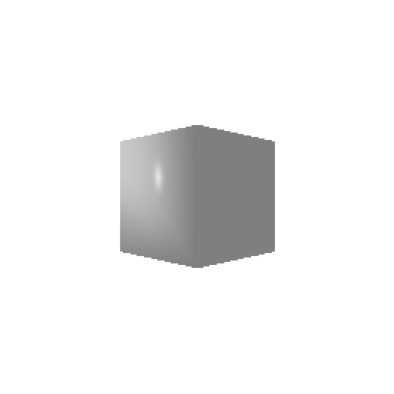

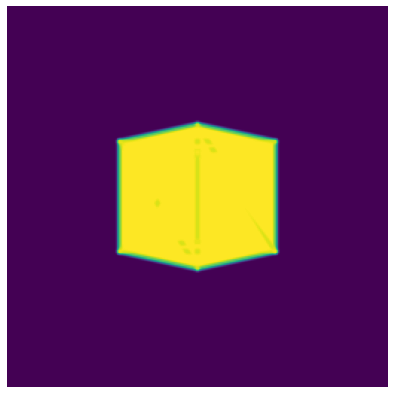

In [11]:
# Render the cube
rendered_cube = rgb_renderer(cube)
plt.figure(figsize=(7, 7))
plt.imshow(rendered_cube[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

# Render silhouette images. 3rd channel of the rendering output is 
# the alpha/silhouette channel
cube_silhouette_image = renderer_silhouette(cube, cameras=cameras, lights=lights)
cube_silhouette = cube_silhouette_image[0, ..., 3]

plt.figure(figsize=(7, 7))
plt.imshow(cube_silhouette.cpu().numpy())
plt.grid("off");
plt.axis("off");

target_silhouette = cube_silhouette
silhouette_image = rendered_cube[0, ..., :3]

# Input Image
The input image can be either a seperate rendering or a sketch. Steps below outline creation of target silhouette from both approaches (note: illustration input can handle multiple objects in a single sketch). 

In [12]:
# Helper function defined for constructing rectilinear mesh from dimensions
def create_rectangle_mesh(src_mesh, new_dim):
    new_verts = src_mesh.verts_packed().clone()
    new_verts[:,0] *= new_dim[0]
    new_verts[:,1] *= new_dim[1]
    new_verts[:,2] *= new_dim[2]

    new_src_mesh = Meshes(verts=[new_verts], faces=[src_mesh.faces_packed()], textures=white_texture)
    return new_src_mesh

### i. Seperate Rendering Input

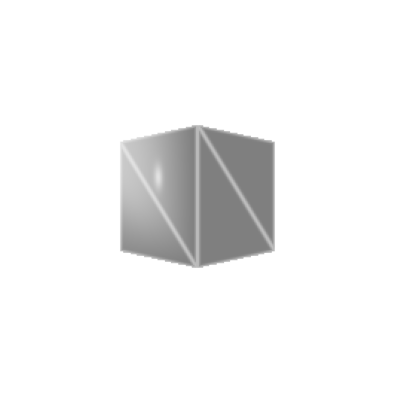

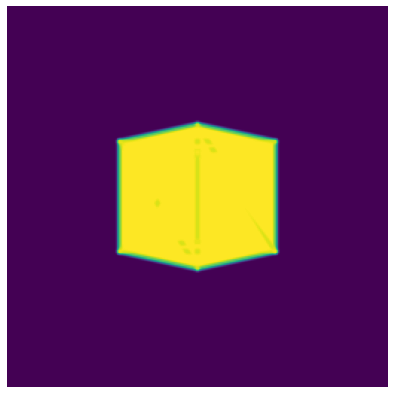

In [13]:
# Decide dimensions of object
manual_dims = [1, 1, 1]
manual_object = create_rectangle_mesh(cube, manual_dims)
target_image = rgb_renderer(manual_object)[0]

# Create target image and silhouette by rendering mesh
silhouette_image = renderer_silhouette(manual_object, cameras=cameras, lights=lights)[0]
target_silhouette = silhouette_image[..., 3]
target_object = manual_object

# Show resulting images
plt.figure(figsize=(7, 7))
plt.imshow(target_image.cpu().numpy())
plt.grid("off");
plt.axis("off");

plt.figure(figsize=(7, 7))
plt.imshow(target_silhouette.cpu().numpy())
plt.grid("off");
plt.axis("off");

### ii. Sketch Input

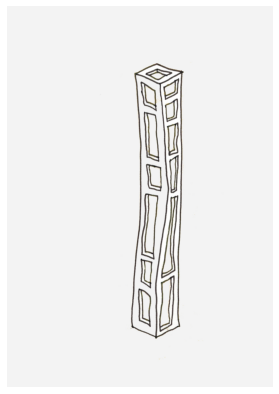

In [15]:
# Upload image and resize
FILEPATH = "/content/yellow_input_nocolor.jpg"
img_in = cv2.imread(FILEPATH, cv2.IMREAD_COLOR)
sketch = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
w = sketch.shape[1]
h = sketch.shape[0]
resized_sketch = cv2.resize(sketch, dsize=(int(sketch.shape[1]/5), int(sketch.shape[0]/5)))
img = cv2.cvtColor(resized_sketch, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(7, 7))
plt.imshow(sketch)
plt.grid("off");
plt.axis("off");

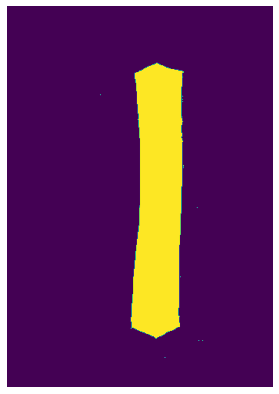

In [16]:
# Find the silhouette of the input sketch...
# Use breadth-first search to find all pixels outside of the sketch's outer lines
visited = np.zeros_like(img)
result = np.ones_like(img)
queue = []
cutoff = 230

# Start in the corner
queue.append((0,0))
result[0,0] = 0

while len(queue) > 0:
  current = queue.pop(0)
  current_y = current[0]
  current_x = current[1]

  # look up 
  if current_y > 0:
    if img[current_y - 1, current_x] > cutoff and visited[current_y - 1, current_x] == 0:
      queue.append((current_y - 1, current_x))
      result[current_y - 1, current_x] = 0
      visited[current_y - 1, current_x] = 1
    
  # look right
  if current_x < img.shape[1] - 1:
    if img[current_y, current_x + 1] > cutoff and visited[current_y, current_x + 1] == 0:
      queue.append((current_y, current_x + 1))
      result[current_y, current_x + 1] = 0
      visited[current_y, current_x + 1] = 1

  # look down
  if current_y < img.shape[0] - 1:
    if img[current_y + 1, current_x] > cutoff and visited[current_y + 1, current_x] == 0:
      queue.append((current_y + 1, current_x))
      result[current_y + 1, current_x] = 0
      visited[current_y + 1, current_x] = 1

  # look left
  if current_x > 0:
    if img[current_y, current_x - 1] > cutoff and visited[current_y, current_x - 1] == 0:
      queue.append((current_y, current_x - 1))
      result[current_y, current_x - 1] = 0
      visited[current_y, current_x - 1] = 1

# Plot the resulting silhouette(s)
plt.figure(figsize=(7, 7))
plt.imshow(result)
plt.grid("off");
plt.axis("off");

In [17]:
# Helper function for searching around silhouette
def define_shape(result, visited, entry):
  bottom = top = entry[0]
  left = right = entry[1]

  # Start at entry
  queue = []
  queue.append(entry)
  
  while len(queue) > 0:
    current = queue.pop(0)
    current_y = current[0]
    current_x = current[1]

    # look up 
    if current_y > 0:
      if result[current_y - 1, current_x] == 1 and visited[current_y - 1, current_x] == 0:
        queue.append((current_y - 1, current_x))
        visited[current_y - 1, current_x] = 1
        # Check for boundary
        if current_y - 1 < top:
          top = current_y - 1
      
    # look right
    if current_x < result.shape[1] - 1:
      if result[current_y, current_x + 1] == 1 and visited[current_y, current_x + 1] == 0:
        queue.append((current_y, current_x + 1))
        visited[current_y, current_x + 1] = 1
        # Check for boundary
        if current_x + 1 > right:
          right = current_x + 1

    # look down
    if current_y < result.shape[0] - 1:
      if result[current_y + 1, current_x] == 1 and visited[current_y + 1, current_x] == 0:
        queue.append((current_y + 1, current_x))
        visited[current_y + 1, current_x] = 1
        # Check boundary
        if current_y + 1 > bottom:
          bottom = current_y + 1

    # look left
    if current_x > 0:
      if result[current_y, current_x - 1] == 1 and visited[current_y, current_x - 1] == 0:
        queue.append((current_y, current_x - 1))
        visited[current_y, current_x - 1] = 1
        if current_x - 1 < left:
          left = current_x - 1

  x = left
  y = top
  w = right - left
  h = bottom - top

  return [(x, y), w, h]

In [18]:
# Conduct a second breadth-first, calling define_shape() one each of the silhouettes
# that the search discovers. Result should be a list of bounding boxes around each 
# of the objects in the input sketch.
visited = np.zeros_like(result)
queue = []
bounding_boxes = []

# Start in the corner
queue.append((0,0))
result[0,0] = 0

while len(queue) > 0:
  current = queue.pop(0)
  current_y = current[0]
  current_x = current[1]

  # look up 
  if current_y > 0:
    if visited[current_y - 1, current_x] == 0:
      visited[current_y - 1, current_x] = 1
      if result[current_y - 1, current_x] == 1:
        bb = define_shape(result, visited, (current_y - 1, current_x))
        if bb[1] > 2 and bb[2] > 2:
          bounding_boxes.append(bb)
      else:
        queue.append((current_y - 1, current_x))

    
  # look right
  if current_x < img.shape[1] - 1:
    if visited[current_y, current_x + 1] == 0:
      visited[current_y, current_x + 1] = 1
      if result[current_y, current_x + 1] == 1:
        bb = define_shape(result, visited, (current_y, current_x + 1))
        if bb[1] > 2 and bb[2] > 2:
          bounding_boxes.append(bb)
      else:
        queue.append((current_y, current_x + 1))

  # look down
  if current_y < img.shape[0] - 1:
    if visited[current_y + 1, current_x] == 0:
      visited[current_y + 1, current_x] = 1
      if result[current_y + 1, current_x] == 1:
        bb = define_shape(result, visited, (current_y + 1, current_x))
        if bb[1] > 2 and bb[2] > 2:
          bounding_boxes.append(bb)
      else:
        queue.append((current_y + 1, current_x))

  # look left
  if current_x > 0:
    if visited[current_y, current_x - 1] == 0:
      visited[current_y, current_x - 1] = 1
      if result[current_y, current_x - 1] == 1:
        bb = define_shape(result, visited, (current_y, current_x - 1))
        if bb[1] > 2 and bb[2] > 2:
          bounding_boxes.append(bb)
      else:
        queue.append((current_y, current_x - 1))

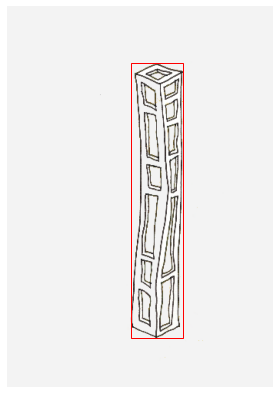

In [19]:
# Plot the bounding boxes over the orignal input
fig,ax = plt.subplots(1, figsize=(7, 7))
ax.imshow(resized_sketch)
for bb in bounding_boxes:
  rect = patches.Rectangle(bb[0],bb[1],bb[2],linewidth=1,edgecolor='red',facecolor='none')
  ax.add_patch(rect)
plt.grid("off");
plt.axis("off");
plt.show()

# Mesh Prediction Via Nerual Rendering

### Helper Functions and Settings

In [20]:
# Show a visualization comparing the rendered predicted mesh to the ground truth mesh
def visualize_prediction(predicted_mesh, 
                         target_image,
                         renderer=rgb_renderer, 
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    predicted_images = renderer(predicted_mesh)
    img_output = predicted_images[0, ..., inds].cpu().detach().numpy()

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title("Input Sketch")
    plt.grid("off");
    plt.axis("off");

    plt.subplot(1, 2, 2)
    plt.title("Final Rendering")
    plt.imshow(img_output)
    plt.grid("off");
    plt.axis("off");

    return img_output

### Optimizer

In [21]:
def render_crop(target_silhouette, target_image, cube=cube):
  # Number of passes through renderer
  Niter = 50

  # Setup tensor with dimensions and optimizer
  new_dim = torch.ones(3, device=device, requires_grad=True)
  optimizer = torch.optim.SGD([new_dim], lr=1.0, momentum=0.9)
  loss_history = []

  loop = tqdm(range(Niter))

  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()
      
      # Create new mesh
      src_mesh = cube.clone()
      new_src_mesh = create_rectangle_mesh(src_mesh, new_dim)

      # Calculate silhouette loss
      predicted_silhouette_image = renderer_silhouette(new_src_mesh, cameras=cameras, lights=lights)
      predicted_silhouette = predicted_silhouette_image[0, ..., 3]
      loss_silhouette = ((predicted_silhouette - target_silhouette) ** 2).mean()

      # Print the losses
      loop.set_description("silhouette loss = %.6f" % loss_silhouette)
      loss_history.append(loss_silhouette)

      # Optimization step
      loss_silhouette.backward()
      optimizer.step()

  img_output = visualize_prediction(new_src_mesh, target_image=target_image)
  return img_output, new_src_mesh

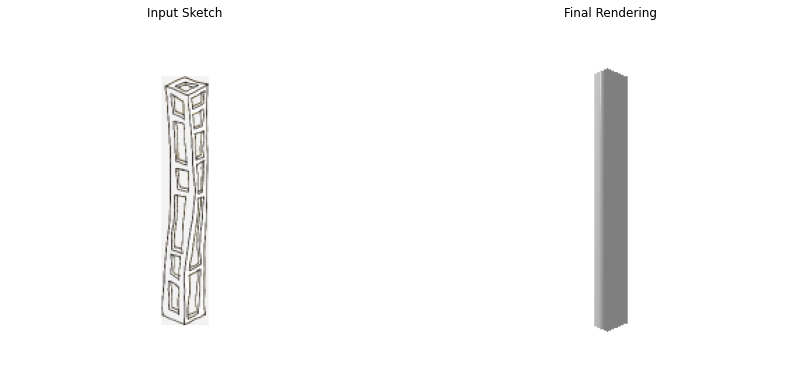

In [22]:
output_renderings = []

for i, bb in enumerate(bounding_boxes):
  coords = bb[0]
  w = bb[1]
  h = bb[2]

  # Setup blank images for targets
  target_silhouette = np.zeros([256, 256])
  target_image = np.zeros([256, 256, 3], dtype=np.uint8)
  target_image.fill(255)

  # Retrieve cropped section of silhouette input
  crop = result[coords[1]:coords[1]+h, coords[0]:coords[0]+w]
  sketch_crop = resized_sketch[coords[1]:coords[1]+h, coords[0]:coords[0]+w]

  target_silhouette = torch.from_numpy(target_silhouette).cuda()
  target_image = torch.from_numpy(target_image).cuda()

  w_scaled = int(w/2)
  h_scaled = int(h/2)
  w_rad = int(w_scaled/2)
  h_rad = int(h_scaled/2)

  resized_crop = cv2.resize(crop, dsize=(w_scaled, h_scaled))
  resized_crop = torch.from_numpy(resized_crop).cuda()
  resized_sketch_crop = cv2.resize(sketch_crop, dsize=(w_scaled, h_scaled))
  resized_sketch_crop = torch.from_numpy(resized_sketch_crop).cuda()

  target_silhouette[128-h_rad:128-h_rad+h_scaled,128-w_rad:128-w_rad+w_scaled] = resized_crop
  target_image[128-h_rad:128-h_rad+h_scaled,128-w_rad:128-w_rad+w_scaled] = resized_sketch_crop

  # Fit a mesh to cropped silhouette
  img_output, mesh_output = render_crop(target_silhouette, target_image)
  cropped_output = img_output[128-h_rad:128-h_rad+h_scaled,128-w_rad:128-w_rad+w_scaled]
  output_renderings.append(cropped_output)

  final_verts, final_faces = mesh_output.get_mesh_verts_faces(0)
  final_obj = os.path.join('./', 'output_' + str(i) + '.obj')
  save_obj(final_obj, final_verts, final_faces)


# Reassemble Image
Optional last step to create a new image that mimics the input using the meshes created in last step. Only to be used with illustration inputs...

In [23]:
# Create canvas for reconstructed image...
if len(bounding_boxes) < 2:
  print("Only one box")
else:
  output = np.zeros_like(resized_sketch,  dtype=np.uint8)
  output.fill(255)

  for i in range(len(bounding_boxes)):
    x = bounding_boxes[i][0][0]
    y = bounding_boxes[i][0][1]
    w = bounding_boxes[i][1]
    h = bounding_boxes[i][2]

    rend = cv2.resize(output_renderings[i], dsize=(w, h))
    output[y:y+h, x:x+w] = rend * 255

  plt.figure(figsize=(20, 15))
  plt.subplot(1, 2, 1)
  plt.imshow(resized_sketch)
  plt.title("Input Sketch")
  plt.grid("off");
  plt.axis("off");

  plt.subplot(1, 2, 2)
  plt.title("Output Rendering")
  plt.imshow(output)
  plt.grid("off");
  plt.axis("off");

Only one box
